In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

from tqdm import tqdm

/Users/sato/dev/cc/sandbox-fabio/python-notebooks/env/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
ds_cfd = xr.open_dataset("../era5/era5-nordics-ecacfd.nc")
ds_fd = xr.open_dataset("../era5/era5-nordics-ecafd.nc")
ds_csu = xr.open_dataset("../era5/era5-nordics-ecacsu.nc")
ds_id = xr.open_dataset("../era5/era5-nordics-ecaid.nc")
ds_su = xr.open_dataset("../era5/era5-nordics-ecasu.nc")

ds_cdd = xr.open_dataset("../era5/era5-nordics-ecacdd.nc")
ds_cwd = xr.open_dataset("../era5/era5-nordics-ecacwd.nc")
ds_pd = xr.open_dataset("../era5/era5-nordics-ecapd.nc")
ds_rr1 = xr.open_dataset("../era5/era5-nordics-ecarr1.nc")
ds_rx1day = xr.open_dataset("../era5/era5-nordics-ecarx1day.nc")
ds_rx5day = xr.open_dataset("../era5/era5-nordics-ecarx5day.nc")
ds_sdii = xr.open_dataset("../era5/era5-nordics-ecasdii.nc")

In [3]:
lons, lats = np.meshgrid(ds_cdd.longitude, ds_cdd.latitude)

In [4]:
lons

array([[ 4.5 ,  4.75,  5.  , ..., 31.5 , 31.75, 32.  ],
       [ 4.5 ,  4.75,  5.  , ..., 31.5 , 31.75, 32.  ],
       [ 4.5 ,  4.75,  5.  , ..., 31.5 , 31.75, 32.  ],
       ...,
       [ 4.5 ,  4.75,  5.  , ..., 31.5 , 31.75, 32.  ],
       [ 4.5 ,  4.75,  5.  , ..., 31.5 , 31.75, 32.  ],
       [ 4.5 ,  4.75,  5.  , ..., 31.5 , 31.75, 32.  ]], dtype=float32)

In [5]:
psr = xr.open_dataset("pine_spruce.nc")

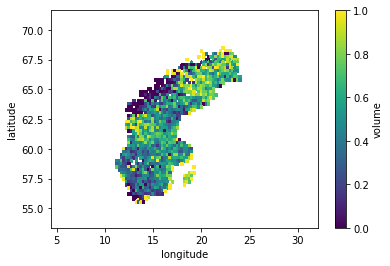

In [6]:
psr.volume.plot()

In [7]:
df = pd.DataFrame()

In [8]:
data = {
    "ratio": psr.volume.values.ravel()
}

In [9]:
data.keys()

dict_keys(['ratio'])

In [11]:
data["cfd"] = ds_cfd.number_of_cfd_periods_with_more_than_5days_per_time_period.values.ravel()
data["fd"] = ds_fd.frost_days_index_per_time_period.values.ravel()
data["csu"] = ds_csu.number_of_csu_periods_with_more_than_5days_per_time_period.values.ravel()
data["id"] = ds_id.ice_days_index_per_time_period.values.ravel()
data["su"] = ds_su.summer_days_index_per_time_period.values.ravel()

In [12]:
data["cdd"] = ds_cdd.number_of_cdd_periods_with_more_than_5days_per_time_period.values.ravel()
data["cwd"] = ds_cwd.number_of_cwd_periods_with_more_than_5days_per_time_period.values.ravel()
data["pd"] = ds_pd.precipitation_days_index_per_time_period.values.ravel()
data["rr1"] = ds_rr1.wet_days_index_per_time_period.values.ravel()
data["rx1day"] = ds_rx1day.highest_one_day_precipitation_amount_per_time_period.values.ravel()
data["rx5day"] = ds_rx5day.highest_five_day_precipitation_amount_per_time_period.values.ravel()
data["sdii"] = ds_sdii.simple_daily_intensity_index_per_time_period.values.ravel()

In [13]:
df = pd.DataFrame(data)

In [14]:
df.head()

,ratio,cdd,cwd,pd,rr1,rx1day,rx5day,sdii,cfd,fd,csu,id,su
0,NaN,118.0,221.0,4157.0,4157.0,64.8069,64.8069,4.414824,89.0,1562.0,0.0,576.0,0.0
1,NaN,122.0,212.0,4134.0,4134.0,64.8069,64.8069,4.450780,86.0,1536.0,0.0,570.0,0.0
2,NaN,116.0,214.0,4122.0,4122.0,64.8069,64.8069,4.475977,83.0,1525.0,0.0,558.0,0.0
3,NaN,113.0,212.0,4121.0,4121.0,64.8069,64.8069,4.441460,84.0,1504.0,0.0,551.0,0.0
4,NaN,114.0,213.0,4117.0,4117.0,64.8069,64.8069,4.403867,78.0,1481.0,0.0,549.0,0.0


In [15]:
df1 = df.dropna(inplace=False)

In [16]:
df1 = df[df["ratio"] > 0]

In [17]:
df1.columns[1:]

Index(['cdd', 'cwd', 'pd', 'rr1', 'rx1day', 'rx5day', 'sdii', 'cfd', 'fd',
       'csu', 'id', 'su'],
      dtype='object')

In [18]:
rf = RandomForestRegressor(n_estimators=500, max_depth=15)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df1[df1.columns[1:]], df1["ratio"])

In [20]:
X_train

,cdd,cwd,pd,rr1,rx1day,rx5day,sdii,cfd,fd,csu,id,su
6483,227.0,62.0,2613.0,2613.0,64.8069,64.8069,5.337658,89.0,2035.0,78.0,701.0,2466.0
3386,204.0,69.0,2712.0,2712.0,64.8069,64.8069,5.494736,127.0,3605.0,77.0,1903.0,1595.0
6246,217.0,111.0,2948.0,2948.0,64.8069,64.8069,6.301251,69.0,1478.0,81.0,463.0,2492.0
6811,213.0,77.0,2789.0,2789.0,64.8069,64.8069,5.565403,83.0,1601.0,65.0,505.0,2384.0
5471,205.0,93.0,2785.0,2785.0,64.8069,64.8069,6.308787,90.0,2001.0,83.0,833.0,2194.0
4044,214.0,58.0,2605.0,2605.0,64.8069,64.8069,5.363391,120.0,3336.0,88.0,1542.0,1776.0
5257,202.0,82.0,2854.0,2854.0,64.8069,64.8069,5.923829,115.0,2563.0,86.0,1125.0,2036.0
2291,240.0,55.0,2562.0,2562.0,64.8069,64.8069,5.524632,109.0,3754.0,74.0,2199.0,1577.0
7032,214.0,64.0,2708.0,2708.0,64.8069,64.8069,5.464377,46.0,982.0,50.0,347.0,2086.0
2508,235.0,64.0,2526.0,2526.0,64.8069,64.8069,5.596797,118.0,3613.0,77.0,2015.0,1722.0


In [21]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
y_pred = rf.predict(X_test)

In [23]:
mean_squared_error(y_test, y_pred)

0.04887818743065015

In [24]:
r2_score(y_test, y_pred)

0.26842500593298224

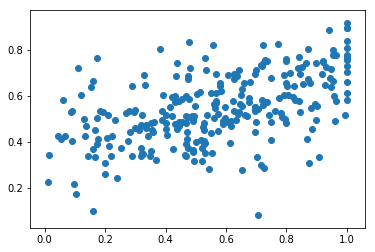

In [25]:
plt.scatter(y_test, y_pred)

In [26]:
df_results = pd.DataFrame({"observed": y_test, "predicted": y_pred},)

In [27]:
df_results

,observed,predicted
6364,0.490042,0.355080
3385,0.828395,0.582919
4249,0.628149,0.534225
5373,0.404473,0.426865
6265,0.901498,0.554687
2717,0.875986,0.308698
2624,0.805608,0.600594
3387,0.717908,0.578754
2183,0.952450,0.661462
5708,0.528472,0.451254


In [28]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [29]:
feature_importances

,importance
su,0.129009
sdii,0.120531
id,0.108756
fd,0.105993
cwd,0.097160
cdd,0.090728
csu,0.088232
cfd,0.086660
rr1,0.085372
pd,0.082912


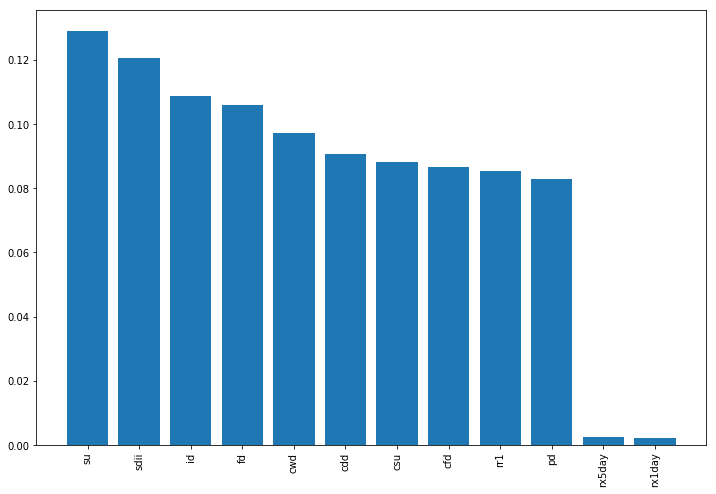

In [30]:
plt.figure(figsize=(12,8))
plt.bar(feature_importances.index, feature_importances["importance"])
plt.xticks(rotation=90)
plt.show()

# Spruce - Classifier

In [31]:
ds_spruce = xr.open_dataset("spruce.nc")

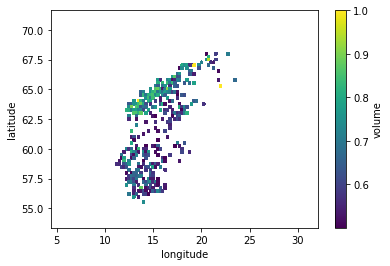

In [32]:
ds_spruce.volume.where(ds_spruce.volume > 0.5).plot()

In [33]:
df2 = df.copy()
df2["ratio"] = ds_spruce.volume.where(ds_spruce.volume > 0.5).values.ravel()
df2["predominant"] = df2.apply(lambda r: 0 if np.isnan(r["ratio"]) else 1, axis=1)
df2.head()

,ratio,cdd,cwd,pd,rr1,rx1day,rx5day,sdii,cfd,fd,csu,id,su,predominant
0,NaN,118.0,221.0,4157.0,4157.0,64.8069,64.8069,4.414824,89.0,1562.0,0.0,576.0,0.0,0
1,NaN,122.0,212.0,4134.0,4134.0,64.8069,64.8069,4.450780,86.0,1536.0,0.0,570.0,0.0,0
2,NaN,116.0,214.0,4122.0,4122.0,64.8069,64.8069,4.475977,83.0,1525.0,0.0,558.0,0.0,0
3,NaN,113.0,212.0,4121.0,4121.0,64.8069,64.8069,4.441460,84.0,1504.0,0.0,551.0,0.0,0
4,NaN,114.0,213.0,4117.0,4117.0,64.8069,64.8069,4.403867,78.0,1481.0,0.0,549.0,0.0,0


In [34]:
X = df2[df2.columns[1:12]]
y = df2["predominant"]

In [35]:
rus = RandomUnderSampler(random_state=1234)

In [36]:
rus.fit(X, y)

RandomUnderSampler(random_state=1234, ratio=None, replacement=False,
          return_indices=False, sampling_strategy='auto')

In [37]:
X_resampled, y_resampled = rus.fit_resample(X, y)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [39]:
rf2 = RandomForestClassifier(n_estimators=500, max_depth=15)

In [40]:
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
y_pred = rf2.predict(X_test)

In [42]:
accuracy_score(y_pred, y_test)

0.8397790055248618

In [43]:
confusion_matrix(y_pred, y_test)

array([[75, 12],
       [17, 77]])

In [44]:
feature_importances = pd.DataFrame(rf2.feature_importances_,
                                   index = df2.columns[1:12],
                                   columns=['importance']).sort_values('importance', ascending=False)

In [45]:
feature_importances

,importance
sdii,0.183219
fd,0.157008
cfd,0.147369
id,0.135311
csu,0.101076
cwd,0.081830
pd,0.061941
rr1,0.061872
cdd,0.060867
rx1day,0.004948


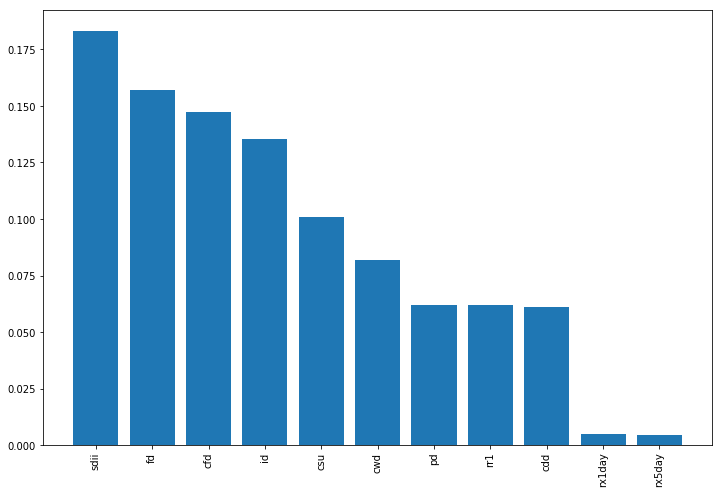

In [46]:
plt.figure(figsize=(12,8))
plt.bar(feature_importances.index, feature_importances["importance"])
plt.xticks(rotation=90)
plt.show()

# Pine - Classifier

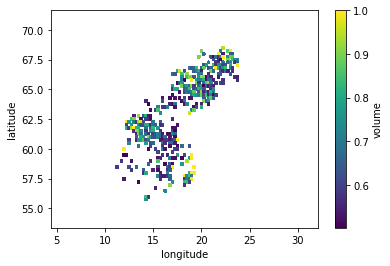

In [47]:
ds_pine = xr.open_dataset("pine.nc")
ds_pine.volume.where(ds_pine.volume > 0.5).plot()

In [48]:
df3 = df.copy()
df3["ratio"] = ds_pine.volume.where(ds_spruce.volume > 0.5).values.ravel()
df3["predominant"] = df3.apply(lambda r: 0 if np.isnan(r["ratio"]) else 1, axis=1)
df3.head()

,ratio,cdd,cwd,pd,rr1,rx1day,rx5day,sdii,cfd,fd,csu,id,su,predominant
0,NaN,118.0,221.0,4157.0,4157.0,64.8069,64.8069,4.414824,89.0,1562.0,0.0,576.0,0.0,0
1,NaN,122.0,212.0,4134.0,4134.0,64.8069,64.8069,4.450780,86.0,1536.0,0.0,570.0,0.0,0
2,NaN,116.0,214.0,4122.0,4122.0,64.8069,64.8069,4.475977,83.0,1525.0,0.0,558.0,0.0,0
3,NaN,113.0,212.0,4121.0,4121.0,64.8069,64.8069,4.441460,84.0,1504.0,0.0,551.0,0.0,0
4,NaN,114.0,213.0,4117.0,4117.0,64.8069,64.8069,4.403867,78.0,1481.0,0.0,549.0,0.0,0


In [49]:
X = df3[df3.columns[1:12]]
y = df3["predominant"]

In [50]:
X_resampled, y_resampled = rus.fit_resample(X, y)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled)

In [52]:
rf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
y_pred = rf2.predict(X_test)

In [54]:
accuracy_score(y_pred, y_test)

0.8729281767955801

In [55]:
confusion_matrix(y_pred, y_test)

array([[75,  7],
       [16, 83]])

In [57]:
feature_importances = pd.DataFrame(rf2.feature_importances_,
                                   index = df2.columns[1:12],
                                   columns=['importance']).sort_values('importance', ascending=False)

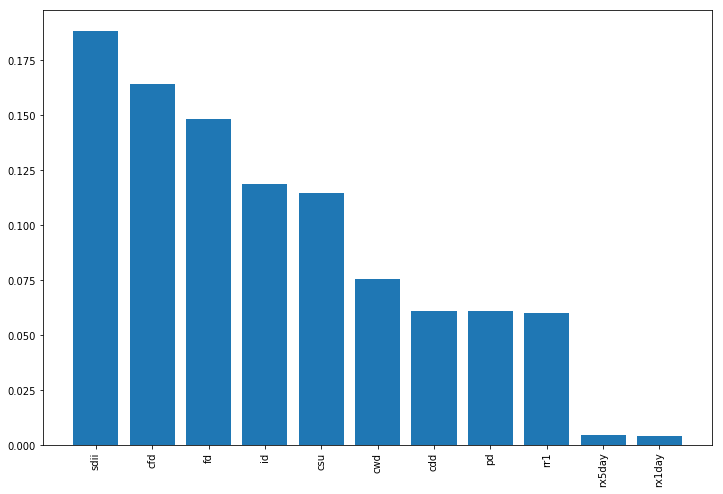

In [58]:
plt.figure(figsize=(12,8))
plt.bar(feature_importances.index, feature_importances["importance"])
plt.xticks(rotation=90)
plt.show()